In [1]:
import pandas as pd
import numpy as np
import keras
from tqdm import tqdm
import sklearn
from matplotlib import pyplot as plt
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

To do:

- Load alle trials i stedte for data (all_readings = np.load('all_readings.npy', allow_pickle=True))
- Ryd op i de trials.
- Generér uniform trials (3D array med [batch, samples,features])
    - Altså, cellen med #Make all trials same length - Save this cell
    - batch er alle dine træningspunkter
    - samples er dine time series (små udklip af eye tracking)
    - features er... ja, features.
- Få LSTM til at virke med din data - skidevære med metrics.
- Når det virker kan du rode rundt med ordentlig klassifikation
- Evt separer saccades og fixations?

In [14]:
target = 'gender' #'age'
even_gender = False

sample_length = 10
seed = 42

epochs=3
verbose=True
batch_size=32

np.random.seed(seed) 

In [3]:
data = np.load('all_readings.npy', allow_pickle=True)
data = [i for i in data if len(i)>sample_length]

if even_gender:
    data = data[:-52]

In [4]:
def make_trials_uniform(trials):
    uniform_X = []
    uniform_y = []
    for trial in tqdm(trials):
        X, y = cleanup_reading(trial)
        length = X.shape[0]
        for i in range(sample_length, length-length%sample_length, sample_length):
            uniform_X.append(X.iloc[i-sample_length:i])
            uniform_y.append(y.values[0])

    return np.array(uniform_X), np.array(uniform_y)


def cleanup_reading(trial):
    trial = trial[trial.columns[1:]]
    trial = trial[trial['eye']=='right']
    trial = trial.drop('eye',1)
    trial = trial.drop('eventIdxLeft',1)
    trial = trial.drop('eventIdxRight',1)
    trial['eventType'] = trial['eventType'].replace(['saccade'], 1)
    trial['eventType'] = trial['eventType'].replace(['fixation'], 0)
    
    trial = trial.fillna(0)
    feats = trial.columns
    trial = trial.reset_index()
    return trial[feats[:-2]], trial[feats[-2:]]

In [5]:
X,y = make_trials_uniform(data)
X,y = sklearn.utils.shuffle(X, y, random_state=seed)

if target == 'gender':
    y = y[:,0] #Only tage gender
else:
    y = y[:,1]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed)

100%|█████████████████████████████████████████████████████████████████████████████| 5584/5584 [00:25<00:00, 219.01it/s]


In [15]:
model = keras.Sequential()
model.add(LSTM(100, input_shape = (10, 12)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer="adam")

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               45200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 55,401
Trainable params: 55,401
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/3
1123/1123 [==============================] - 6s 5ms/step - loss: -2447.0508 - accuracy: 0.5009
Epoch 2/3
1123/1123 [==============================] - 6s 5ms/step - loss: -16745.2578 - accuracy: 0.5010
Epoch 3/3
1123/1123 [==============================] - 6s 5ms/step - loss: -42855.7148 - accuracy: 0.5010


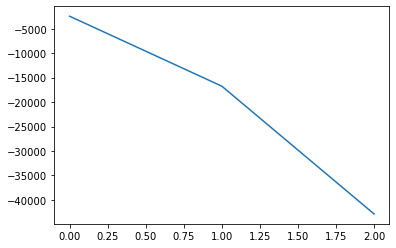

In [17]:
plt.plot(history.history['loss']);

In [18]:
y_pred= model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test-1, y_pred-1)

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dum_y_pred= dummy.predict(X_test).ravel()
dum_fpr, dum_tpr, dum_thresholds = roc_curve(y_test-1, y_pred-1)

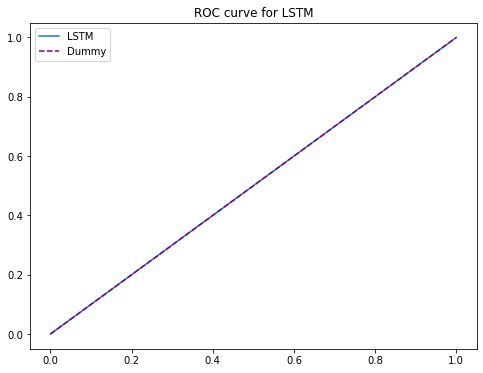

In [19]:
fig = plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label="LSTM")
plt.plot(dum_fpr,dum_tpr,'--',label="Dummy", c='purple')
plt.title("ROC curve for LSTM")
plt.legend()

In [11]:
np.bincount(y.astype(int))

array([   0, 7470, 7499], dtype=int64)

In [24]:
np.bincount(model.predict(X_test).ravel().astype(int))

array([   0, 3743], dtype=int64)

array([[ 36.        ,   0.        ,   1.        ,   0.        ,
          0.        , 953.637     , 217.946     , 513.494     ,
        393.107     ,   0.        ,   0.        ,   0.        ],
       [564.        ,   3.77989643,   0.        , 434.56587324,
        380.90603521,   0.        ,   0.        ,   0.        ,
          0.        ,   3.        ,   7.81057172,  39.0419566 ],
       [ 20.        ,   0.        ,   1.        ,   0.        ,
          0.        , 381.032     , 365.377     , 482.942     ,
        369.093     ,   0.        ,   0.        ,   0.        ],
       [380.        ,   3.73101053,   0.        , 497.5974375 ,
        378.60046875,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   5.51383721,  16.72453877],
       [ 16.        ,   0.        ,   1.        ,   0.        ,
          0.        , 499.426     , 378.313     , 426.635     ,
        375.036     ,   0.        ,   0.        ,   0.        ],
       [620.        ,   3.75040968,